In [207]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import random
import math
from matplotlib import pyplot
from random import randrange

import matplotlib.cm as cm #Used to display images in a specific colormap
from scipy.optimize import fmin_bfgs

In [208]:
mat = scipy.io.loadmat('machine-learning-ex4/ex4/ex4data1.mat')
X = mat['X']
y = mat['y'].flatten()
y[y==10]=0
m = y.size

thetas = scipy.io.loadmat('machine-learning-ex4/ex4/ex4weights.mat')
theta1 = thetas['Theta1']
theta2 = thetas['Theta2']
theta = np.concatenate((theta1.ravel(),theta2.ravel()),axis=0)

In [209]:
# THE FOLLOWING BLOCK WAS FOUND USING ONLINE RESOURCE 

def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Display Image
        h = ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

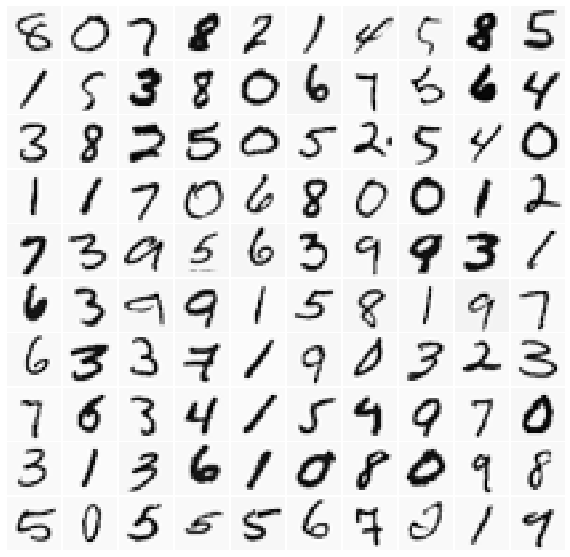

In [210]:
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]
displayData(sel)

In [211]:
def initializeWeights(layerIn,layerOut):
    epsilon = math.sqrt(6)/math.sqrt(layerIn+layerOut+1)
    w = np.zeros((layerIn,layerOut))
    for i in range(layerIn):
        for j in range(layerOut):
            w[i][j] = random.uniform(-epsilon,epsilon)
    return w

def turnNumToVector(x,m):
    ret = np.zeros((m))
    ret[x]=1
    return ret

In [212]:
def sigmoid(x):
    return(1 / (1 + np.exp(-x)))

def predict(theta1,theta2,X):
    if(X.shape==1):
        X = X[:,np.newaxis]
    X = np.append(1,X)
    
    hidden = np.zeros((hidden_layer_size,1))
    hidden = theta1.dot(X)
    hidden = sigmoid(hidden)

    hidden = np.append(1,hidden)
    output = theta2.dot(hidden)
    return sigmoid(np.roll(output,1))

def sigmoidGradient(z):
    g = sigmoid(z)
    return g*(1-g)

In [213]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lamb=0):

    theta1size = (input_layer_size+1)*hidden_layer_size

    theta1 = np.reshape(nn_params[0:theta1size],(hidden_layer_size,input_layer_size+1))
    theta2 = np.reshape(nn_params[theta1size:theta1size+(hidden_layer_size+1)*num_labels],(num_labels,hidden_layer_size+1))
    hx = np.zeros((num_labels,m))
    hy = np.zeros((num_labels,m))

    delta1 = np.zeros((theta1.shape))
    delta2 = np.zeros((theta2.shape))
    
    
    for sub in range(0,m):
        yVec = turnNumToVector(y[sub],num_labels)[:,np.newaxis]
        a1 = X[sub][:,np.newaxis]
        
        a1 = np.vstack((1,a1))
     
        z2 = theta1.dot(a1)
        a2 = sigmoid(z2)
        a2 = np.vstack((1,a2))    
        z3 = theta2.dot(a2)
        a3 = sigmoid(np.roll(z3,1))

        hx[:,sub]=a3[:,0]
        hy[:,sub]=yVec[:,0]

        s3 = a3 - yVec
        s2 = theta2[:,1:].T.dot(s3)*sigmoidGradient(z2) 
        delta1 += s2.dot(a1.T)
        delta2 += s3.dot(a2.T)

    theta1Grad = delta1/m
    theta2Grad = delta2/m
    J = 0
    J += -np.sum(np.log(hx)*(hy))-np.sum(np.log(1-hx)*(1-hy))
    J /=m

    J += lamb/(2*m)*(np.sum(np.power(theta1[:,1:],2)))
    J += lamb/(2*m)*(np.sum(np.power(theta2[:,1:],2)))
    return (J,np.concatenate([theta1Grad.ravel(), theta2Grad.ravel()]))

nnCostFunction(theta,input_layer_size,hidden_layer_size,num_labels,X,y,1)


(0.38376985909092365,
 array([0.0012188 , 0.        , 0.        , ..., 0.00050063, 0.00113453,
        0.00135707]))

In [214]:
def debugInitializeWeights(fan_out, fan_in):
    """
    Initialize the weights of a layer with fan_in incoming connections and fan_out outgoings
    connections using a fixed strategy. This will help you later in debugging.
    Note that W should be set a matrix of size (1+fan_in, fan_out) as the first row of W handles
    the "bias" terms.
    Parameters
    ----------
    fan_out : int
        The number of outgoing connections.
    fan_in : int
        The number of incoming connections.
    Returns
    -------
    W : array_like (1+fan_in, fan_out)
        The initialized weights array given the dimensions.
    """
    # Initialize W using "sin". This ensures that W is always of the same values and will be
    # useful for debugging
    W = np.sin(np.arange(1, 1 + (1+fan_in)*fan_out))/10.0
    W = W.reshape(fan_out, 1+fan_in, order='F')
    return W
def checkNNGradients(nnCostFunction, lambda_=0):
    """
    Creates a small neural network to check the backpropagation gradients. It will output the
    analytical gradients produced by your backprop code and the numerical gradients
    (computed using computeNumericalGradient). These two gradient computations should result in
    very similar values.
    Parameters
    ----------
    nnCostFunction : func
        A reference to the cost function implemented by the student.
    lambda_ : float (optional)
        The regularization parameter value.
    """
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)

    # Reusing debugInitializeWeights to generate X
    X = debugInitializeWeights(m, input_layer_size - 1)
    y = np.arange(1, 1+m) % num_labels
    # print(y)
    # Unroll parameters
    nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

    # short hand for cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size,
                                        num_labels, X, y, lambda_)
    cost, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)

    # Visually examine the two gradient computations.The two columns you get should be very similar.
    print(np.stack([numgrad, grad], axis=1))
    print('The above two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)\n')


    diff = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)

    return diff
def computeNumericalGradient(J, theta, e=1e-4):
    """
    Computes the gradient using "finite differences" and gives us a numerical estimate of the
    gradient.
    Parameters
    ----------
    J : func
        The cost function which will be used to estimate its numerical gradient.
    theta : array_like
        The one dimensional unrolled network parameters. The numerical gradient is computed at
         those given parameters.
    e : float (optional)
        The value to use for epsilon for computing the finite difference.
    Notes
    -----
    The following code implements numerical gradient checking, and
    returns the numerical gradient. It sets `numgrad[i]` to (a numerical
    approximation of) the partial derivative of J with respect to the
    i-th input argument, evaluated at theta. (i.e., `numgrad[i]` should
    be the (approximately) the partial derivative of J with respect
    to theta[i].)
    """
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad
checkNNGradients(nnCostFunction)

IndexError: index 5 is out of bounds for axis 0 with size 5